# 2. Incorporating Risk Management in the Analysis

In [1]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
import re
pd.set_option('display.max_row', None)

In [2]:
########################################
########### IMPORT DATA ################
########################################

# Import drug data using pandas
data = pd.read_csv('drugs.csv', index_col=0)
projects = data.columns
t_area = data.iloc[0]
ttm = data.iloc[1]
ret = data.iloc[2]
cost = data.iloc[3]

#import covariance matrix
cov=pd.read_csv('drugs_cov.csv', index_col=0)

#therapeutic areas
ther=[
"Oncology", "Cardiovascular", "Respiratory and dermatology", "Transplantation",
"Rheumatology and hormone therapy", "Central nervous system", "Ophtalmics"]

#budget constraints for therapeutic areas
t_bud={"Oncology": 100,
       "Cardiovascular": 200,
       "Respiratory and dermatology": 150,
       "Transplantation": 100,
       "Rheumatology and hormone therapy": 300,
       "Central nervous system": 100,
       "Ophtalmics": 50}

interest_rate=0.03


# 2.1.a Efficient Frontier with a Variance Constraint

### Plot a frontier efficient curve by setting the variance constraint ranging from 0 to the possible maximum variance

In [21]:
def frontier():
    
    ret_std = {"return":[], "stdDev":[]}
    max_var = sum(cov.sum())
    
    for varConstr in np.linspace(0, max_var, 100):
        # an empty model
        m = gp.Model('portfolio')

        # Decision variables
        vars = pd.Series(m.addVars(projects, vtype=GRB.BINARY, name="projects"))
        
        # Constraints
        m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == "Oncology") <= 100)
        m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Cardiovascular') <= 200)
        m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Respiratory and dermatology') <= 150)
        m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Transplantation') <= 100)
        m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Rheumatology and hormone therapy') <= 300)
        m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Central nervous system') <= 100)
        m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Ophtalmics') <= 50)

        m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["1"]) >= 0.15*sum(vars[t] for t in range(len(projects))))
        m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["2","3"]) >= 0.2*sum(vars[t] for t in range(len(projects))))
        m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["4","5"]) >= 0.25*sum(vars[t] for t in range(len(projects))))
        
        
        # Constraint for variance
        portfolio_var = np.dot(np.dot(vars.T, cov), vars)
        m.addConstr(portfolio_var <= varConstr)

        # Objective function
        obj = ret.T @ vars + (1000-(cost.T @ vars))*(1+interest_rate)
        m.setObjective(obj, GRB.MAXIMIZE)
        
        # Find Solution
        m.setParam('OutputFlag', 0)
        m.optimize()

        # Put the optimized return and the corresponding standard deviation in the dictionary
        ret_std["return"].append(round(m.objVal, 3))
        ret_std["stdDev"].append(round(sqrt(portfolio_var.getValue()),3))
        
    return ret_std, vars, m

In [22]:
tic = time.time()
ret_std, vars, m = frontier()
toc = time.time() - tic
print("running time: %d" %toc, "sec")

running time: 129 sec


In [23]:
# ADD PRINTING HERE:
# Print optimal value of the objective function
print('\nValue of objective function- \nExpected Return at the risk neutral level: \n$%g' % m.objVal,"(Million)")

# Print optimal values for the decision variables
print('\nDecision variables- \nSelected Projects at the risk neutral level:\n')
for v in m.getVars():
    if v.x >= 0.5:
        print('%s = %g' % (v.varName, v.x))

# Print the number of funded projects
temp=0
for v in m.getVars():
    if v.x>0.5:
        temp=temp+1
print('\nNumber of selected projects at the risk neutral level:\n', temp)

# Print total cost (buget spent on projects)
total_cost = round((vars.T @ cost).getValue(), 4)
print('\nTotal cost at the risk neutral level:\n$%g' % total_cost , "(Million)")

# Print the proportion of the budget spent on projects
print('\nPercent of the overall budget used for drug development at the risk neutral level:\n', round(total_cost/10, 4), "%")


Value of objective function- 
Expected Return at the risk neutral level: 
$23142.1 (Million)

Decision variables- 
Selected Projects at the risk neutral level:

projects[3] = 1
projects[4] = 1
projects[6] = 1
projects[13] = 1
projects[15] = 1
projects[17] = 1
projects[18] = 1
projects[20] = 1
projects[21] = 1
projects[22] = 1
projects[24] = 1
projects[25] = 1
projects[27] = 1
projects[28] = 1
projects[29] = 1
projects[30] = 1
projects[39] = 1
projects[40] = 1
projects[42] = 1
projects[43] = 1
projects[44] = 1
projects[47] = 1
projects[48] = 1
projects[50] = 1
projects[57] = 1
projects[58] = 1
projects[62] = 1
projects[66] = 1
projects[69] = 1
projects[72] = 1
projects[76] = 1
projects[77] = 1
projects[78] = 1
projects[86] = 1
projects[91] = 1
projects[98] = 1
projects[99] = 1
projects[101] = 1
projects[102] = 1
projects[104] = 1
projects[105] = 1
projects[106] = 1
projects[109] = 1
projects[110] = 1
projects[111] = 1
projects[112] = 1

Number of selected projects at the risk neutral l

In [24]:
# return and stdDev data for efficient frontier curve 
frontier_df = pd.DataFrame(ret_std)
frontier_df

,return,stdDev
0,1030.000,0.000
1,4840.610,522.670
2,7137.641,737.895
3,8522.796,903.597
4,9529.418,1045.013
5,10365.220,1168.382
6,11145.476,1277.815
7,11701.058,1382.789
8,12221.592,1478.662
9,12663.999,1568.332


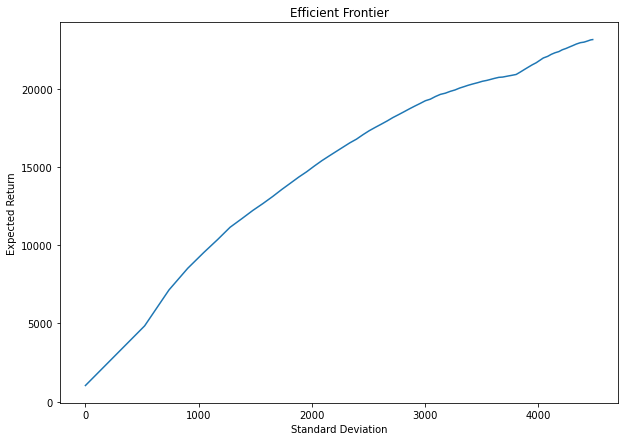

In [25]:
# Plot efficient frontier
plt.figure(figsize = (10,7))
plt.plot("stdDev", "return", data = frontier_df)
plt.xlabel("Standard Deviation")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")
plt.show()

In [26]:
# create a df for the slopes of the efficient frontier curve
slope_dct = {"Std_Dev":frontier_df.loc[1:,"stdDev"], "slope":[]}

t=0
for i in range(99):
    if t <= 98:
        y = frontier_df.iloc[i+1,0] - frontier_df.iloc[i,0]
        x = frontier_df.iloc[i+1,1] - frontier_df.iloc[i,1]
        if y == 0 and x ==0:
            slp = 0
        else:slp = y/x
        slope_dct["slope"].append(slp)
    t += 1
    
slope_df = pd.DataFrame(slope_dct)
slope_df["row_id"] = slope_df.index
slope_df

,Std_Dev,slope,row_id
1,522.670,7.290661,1
2,737.895,10.672696,2
3,903.597,8.359314,3
4,1045.013,7.118162,4
5,1168.382,6.774814,5
6,1277.815,7.129988,6
7,1382.789,5.292568,7
8,1478.662,5.429412,8
9,1568.332,4.933724,9
10,1653.177,5.227073,10


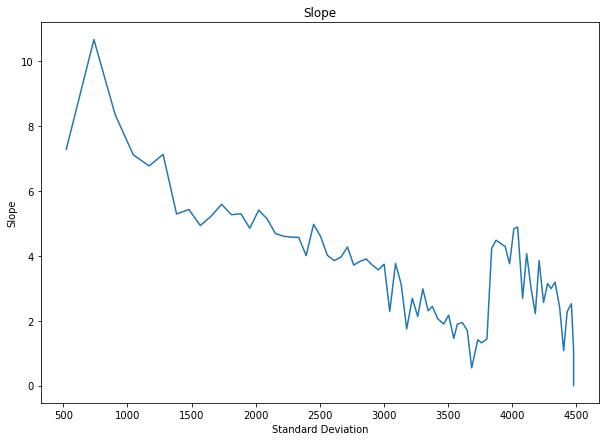

In [27]:
# Plot slope chart
plt.figure(figsize = (10,7))
plt.plot("Std_Dev","slope", data = slope_df)
plt.xlabel("Standard Deviation")
plt.ylabel("Slope")
plt.title("Slope")
plt.show()

In [28]:
# create a df only including the standard deviations at which the slopes increase (get steeper)
peak_ = {"row_id":[],"Peak_Std_Dev":[]} # row_id of each instance is equal to the index of the corresponding instance of frontier_df
for i in range(1,len(slope_df)):
    if slope_df.iloc[i, 1] - slope_df.iloc[i-1, 1] > 0:
        peak_["Peak_Std_Dev"].append(slope_df.iloc[i, 0])
        peak_["row_id"].append(slope_df.iloc[i, 2])
peak_df = pd.DataFrame(peak_)
peak_df

,row_id,Peak_Std_Dev
0,2,737.895
1,6,1277.815
2,8,1478.662
3,10,1653.177
4,11,1733.906
5,13,1884.823
6,15,2024.090
7,22,2451.998
8,26,2665.610
9,27,2716.559


In [29]:
# Return & Risk at the risk neutral point
RN_return = frontier_df.iloc[-1,0]
RN_risk = frontier_df.iloc[-1,1]
print("Return of the Risk Neutral:\n", RN_return)
print("\nStandard Deviation of the Risk Neutral:\n", RN_risk)

Return of the Risk Neutral:
 23142.146

Standard Deviation of the Risk Neutral:
 4480.672


In [30]:
# Add columns to the peak_df for the percentage changes of risk and returns between the risk neutral point and each increasing slope
return_prct_chng_list = []
risk_prct_chng_list = []
for j in range(len(peak_df)):
    return_prct_chng = 100*((frontier_df.loc[peak_df.iloc[j, 0], "return"] - RN_return)/RN_return)
    risk_prct_chng = 100*((frontier_df.loc[peak_df.iloc[j, 0], "stdDev"] - RN_risk)/RN_risk)
    return_prct_chng_list.append(round(return_prct_chng, 2))
    risk_prct_chng_list.append(round(risk_prct_chng,2))

peak_df["return_prct_chng"] = return_prct_chng_list
peak_df["risk_prct_chng"] = risk_prct_chng_list

# Add the column that has the value of marginal percent change of risk with respect to returns
# marginal percent change of risk refers to:
# how much percentage of risk is changed (reduced) when forgoing 1% of return comparing to the risk neutral level. 
peak_df["marginal_risk_change_ratio"] = round(peak_df["risk_prct_chng"]/peak_df["return_prct_chng"],2)

peak_df

,row_id,Peak_Std_Dev,return_prct_chng,risk_prct_chng,marginal_risk_change_ratio
0,2,737.895,-69.16,-83.53,1.21
1,6,1277.815,-51.84,-71.48,1.38
2,8,1478.662,-47.19,-67.00,1.42
3,10,1653.177,-43.36,-63.10,1.46
4,11,1733.906,-41.41,-61.30,1.48
5,13,1884.823,-37.96,-57.93,1.53
6,15,2024.090,-34.88,-54.83,1.57
7,22,2451.998,-26.26,-45.28,1.72
8,26,2665.610,-22.47,-40.51,1.80
9,27,2716.559,-21.53,-39.37,1.83


* when standard deviation is 4463.391, the marginal percentage change of risk with respect to returns is largest

## Remodel with the best variance constraint detected above

In [31]:
########################################
########### MODEL ######################
########################################

# Create an empty model
m = gp.Model('portfolio')

# ADD DECISION VARIABLES HERE
vars = pd.Series(m.addVars(projects, vtype=GRB.BINARY, name="projects"))

########################################
#### CONSTRAINTS & OBJ FUNCTIONS #######
########################################

# ADD CONSTRAINTS HERE

# Maximum Cost by Therapeutic Area
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == "Oncology") <= 100)
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Cardiovascular') <= 200)
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Respiratory and dermatology') <= 150)
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Transplantation') <= 100)
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Rheumatology and hormone therapy') <= 300)
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Central nervous system') <= 100)
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Ophtalmics') <= 50)


# Pipeline Constraints
m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["1"]) >= 0.15*sum(vars[t] for t in range(len(projects))))
m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["2", "3"]) >= 0.2*sum(vars[t] for t in range(len(projects))))
m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["4", "5"]) >= 0.25*sum(vars[t] for t in range(len(projects))))


# Constraint for variance
portfolio_var = np.dot(np.dot(vars.T, cov), vars)
recommended_stdDev =  peak_df.loc[peak_df["marginal_risk_change_ratio"] == max(peak_df["marginal_risk_change_ratio"]), "Peak_Std_Dev"]
m.addConstr(portfolio_var <= ((int(recommended_stdDev)+1)**2)) # add 1 to "recommended_stdDev" to a little bit loosen the upper bound of the variance constraint
        
# ADD OBJECTIVE FUNCTION HERE
obj = ret.T @ vars + (1000-(cost.T @ vars))*(1+interest_rate)

m.setObjective(obj, GRB.MAXIMIZE)
m.setParam('OutputFlag', 0)
m.optimize()

# ADD PRINTING HERE:
# Print optimal value of the objective function
print('\nValue of objective function \nExpected Return: \n$%g' % m.objVal,"(Million)")

# Print optimal values for the decision variables
print('\nDecision variables \nSelected Projects:\n')
for v in m.getVars():
    if v.x >= 0.5:
        print('%s = %g' % (v.varName, v.x))

# Print the number of funded projects
temp=0
for v in m.getVars():
    if v.x>0.5:
        temp=temp+1
print('\nNumber of selected projects:', temp)

# Print total cost (buget spent on projects)
total_cost = round((vars.T @ cost).getValue(), 4)
print('\nTotal cost: $%g' % total_cost , "(Million)")

# Print the proportion of the budget spent on projects
print('\nPercent of the overall budget used for drug development:\n', round(total_cost/10, 4), "%")

# Print the portfolio variance when maximizing return  
portfolio_stdDev = sqrt((np.dot(np.dot(vars.T, cov), vars)).getValue())
print("\nPortfolio standard deviation when maximizing return:", round(portfolio_stdDev,4))


Value of objective function 
Expected Return: 
$23123 (Million)

Decision variables 
Selected Projects:

projects[3] = 1
projects[4] = 1
projects[6] = 1
projects[13] = 1
projects[17] = 1
projects[18] = 1
projects[20] = 1
projects[21] = 1
projects[22] = 1
projects[24] = 1
projects[25] = 1
projects[27] = 1
projects[28] = 1
projects[29] = 1
projects[30] = 1
projects[39] = 1
projects[40] = 1
projects[42] = 1
projects[43] = 1
projects[44] = 1
projects[45] = 1
projects[47] = 1
projects[48] = 1
projects[50] = 1
projects[57] = 1
projects[58] = 1
projects[62] = 1
projects[66] = 1
projects[69] = 1
projects[72] = 1
projects[76] = 1
projects[77] = 1
projects[78] = 1
projects[86] = 1
projects[91] = 1
projects[98] = 1
projects[99] = 1
projects[101] = 1
projects[102] = 1
projects[104] = 1
projects[105] = 1
projects[106] = 1
projects[109] = 1
projects[110] = 1
projects[111] = 1
projects[112] = 1

Number of selected projects: 46

Total cost: $873.37 (Million)

Percent of the overall budget used for dr

### Steps for deriving a recommendation from the efficient frontier, of which returns continuously go up as risks increase
#### 1) Calculate the slope of the frontier curve by each range of standard deviation and plot them on a line chart.
* a slope refers to the marginal increase in returns as risks increase 
* the slope chart shows that every slope of the frontier curve is positive
* the slope becomes exponentially steeper at the standard deviation of 737.895 and then the overall trend gradually decreases with multiple fluctuations
* the slope rebounds up at the standard deviation of 3841.543 and goes up slightly more and then decreases again with big fluctuations
* It implies that it is hard to find a specific point where we can minimize the loss of returns reducing risks significantly since there's no range of standard deviation where the slope of frontier curve turns to the negative direction or at least flatten

#### 2) Create a data frame (peak_df) consisting of only the standard deviations where the slopes of the frontier curve increase.
* such points can give more efficiencies in reducing the loss of returns along with the risk reduction compared to the points where the slopes decrease

#### 3) Calculate the percentage changes from  the risk neutral point to each points in peak_df
* risk neutral point(no variance constraint): Standard Deviation = 23142.146, Return = 4480.672 
* calculate the percent change of risk and return from the risk neutral point to each of the points in peak_df
* add the computed percentage change values to the peak_df

#### 4) Compare the efficiency of each point based on the marginal percent change of risk with respect to returns
* percent change of risk / percent change of return
* it represents how much percent of risks decrease at a specific point as returns decrease by 1% from the risk neutral point
* when taking risk by about 4,463 standard deviation, we get the highest marginal percentage change of risk which 4.88
* returns at the risk neutral - returns at the most efficient point = 23142.146 - 23122.969 = 19.177(M dollars) should be forgone
* stdDev at the risk neutral - stdDev at the most efficient point = 4480.672 - 4463.391 = 17.281 (reduced)

#### Recommendation with summary
* the goal is to maximize returns but the company should forgo some returns if the loss of returns reduces risks significantly 
* the term "significantly" is ambiguous so I found a point that offers relatively more efficiency in a sense that more risks are reduced given the same reduction in returns compared to the risk neutral point
* the standard deviation (risk) which the company should take is about 4463.391
* the company should sacrifice returns by 19.177(M dollars) then they can reduce risks by 17.281 (standard deviation)


# 2.1.b Minimizing Risk

In [16]:
########################################
########### MODEL ######################
########################################

# Create an empty model
m = gp.Model('portfolio')

# ADD DECISION VARIABLES HERE
vars = pd.Series(m.addVars(projects, vtype=GRB.BINARY, name="projects"))

########################################
#### CONSTRAINTS & OBJ FUNCTIONS #######
########################################

# ADD CONSTRAINTS HERE
# Maximum Cost by Therapeutic Area
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == "Oncology") <= 100)
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Cardiovascular') <= 200)
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Respiratory and dermatology') <= 150)
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Transplantation') <= 100)
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Rheumatology and hormone therapy') <= 300)
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Central nervous system') <= 100)
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Ophtalmics') <= 50)


# Pipeline Constraints
m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["1"]) >= 0.15*sum(vars[t] for t in range(len(projects))))
m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["2", "3"]) >= 0.2*sum(vars[t] for t in range(len(projects))))
m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["4", "5"]) >= 0.25*sum(vars[t] for t in range(len(projects))))


# ADD OBJECTIVE FUNCTION HERE
# Minimizing Portfolio Variance
obj = np.dot(np.dot(vars.T, cov), vars)
m.setObjective(obj, GRB.MINIMIZE)

m.setParam('OutputFlag', 0)
m.optimize()


# ADD PRINTING HERE:
# Print optimal value of the objective function
print('\nValue of objective function \nPortfolio Variance: \n%g' % m.objVal)
print('\nPortfolio StdDev: \n%g' % sqrt(m.objVal))

# Expected Returns
returns = ret.T @ vars + (1000-(cost.T @ vars))*(1+interest_rate)
print("\nExpected Returns: $", returns.getValue(), "(Million)")

# Print optimal values for the decision variables
print('\nDecision variables \nSelected Projects:\n')
for v in m.getVars():
    if v.x >= 0.5:
        print('%s = %g' % (v.varName, v.x))

# Print the number of funded projects
temp=0
for v in m.getVars():
    if v.x>0.5:
        temp=temp+1
print('\nNumber of selected projects:', temp)

# Print total cost (buget spent on projects)
total_cost = round((vars.T @ cost).getValue(), 4)
print('\nTotal cost: $%g' % total_cost , "(Million)")

# Print the proportion of the budget spent on projects
print('\nPercent of the overall budget used for drug development:\n', round(total_cost/10, 4), "%")


Value of objective function 
Portfolio Variance: 
0

Portfolio StdDev: 
0

Expected Returns: $ 1030.0 (Million)

Decision variables 
Selected Projects:


Number of selected projects: 0

Total cost: $0 (Million)

Percent of the overall budget used for drug development:
 0.0 %


# 2.2.a Additional Donation

In [3]:
########################################
########### MODEL ######################
########################################

# Create an empty model
m = gp.Model('portfolio')

# ADD DECISION VARIABLES HERE
vars = pd.Series(m.addVars(projects, vtype=GRB.BINARY, name="projects"))
y = m.addVars(len(t_area.unique()), vtype=GRB.BINARY, name = "y")

########################################
#### CONSTRAINTS & OBJ FUNCTIONS #######
########################################

# ADD CONSTRAINTS HERE
# Maximum Cost by Therapeutic Area
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == "Oncology") <= 100+(50*y[0]))
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Cardiovascular') <= 200+(50*y[1]))
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Respiratory and dermatology') <= 150+(50*y[2]))
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Transplantation') <= 100+(50*y[3]))
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Rheumatology and hormone therapy') <= 300+(50*y[4]))
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Central nervous system') <= 100+(50*y[5]))
m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Ophtalmics') <= 50+(50*y[6]))


# Pipeline Constraints
m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["1"]) >= 0.15*sum(vars[t] for t in range(len(projects))))
m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["2", "3"]) >= 0.2*sum(vars[t] for t in range(len(projects))))
m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["4", "5"]) >= 0.25*sum(vars[t] for t in range(len(projects))))


# Constraint for y 
m.addConstr(sum(y[j] for j in range(len(y))) == 1)


# ADD OBJECTIVE FUNCTION HERE
obj = ret.T @ vars + (1050-(cost.T @ vars))*(1+interest_rate)
m.setObjective(obj, GRB.MAXIMIZE)

m.setParam('OutputFlag', 0)
m.optimize()

# ADD PRINTING HERE:
# Print optimal value of the objective function
print('\nValue of objective function \nExpected Return: \n$%g' % m.objVal,"(Million)")

# Print optimal values for the decision variables
print('\nDecision variables \nSelected Projects:\n')
for v in m.getVars():
    if v.x >= 0.5:
        print('%s = %g' % (v.varName, v.x))

# Print the number of funded projects
temp=0
for v in m.getVars():
    if v.x>0.5:
        temp=temp+1
print('\nNumber of selected projects:', temp-1)

# Print the therapeutic area to which the additional donation allocated
for v in m.getVars():
    if "y" in v.varName and v.x >= 0.5:
        ther_idx = int(re.findall(r'\d{1}',v.varName)[0])
        print("selected therapeutic area:", ther[ther_idx])

# Print total cost (buget spent on projects)
total_cost = round((vars.T @ cost).getValue(), 4)
print('\nTotal cost: $%g' % total_cost , "(Million)")

# Print the proportion of the budget spent on projects
print('\nPercent of the overall budget used for drug development:\n', round(total_cost/10, 4), "%")

# Print the portfolio variance when maximizing return  
portfolio_stdDev = sqrt((np.dot(np.dot(vars.T, cov), vars)).getValue())
print("\nPortfolio standard deviation when maximizing return:", round(portfolio_stdDev,4))


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-12-04
Using license file /Users/alex/gurobi.lic

Value of objective function 
Expected Return: 
$23848 (Million)

Decision variables 
Selected Projects:

projects[3] = 1
projects[4] = 1
projects[5] = 1
projects[6] = 1
projects[7] = 1
projects[11] = 1
projects[13] = 1
projects[15] = 1
projects[16] = 1
projects[17] = 1
projects[18] = 1
projects[20] = 1
projects[21] = 1
projects[22] = 1
projects[24] = 1
projects[25] = 1
projects[27] = 1
projects[28] = 1
projects[29] = 1
projects[30] = 1
projects[40] = 1
projects[42] = 1
projects[43] = 1
projects[44] = 1
projects[45] = 1
projects[46] = 1
projects[47] = 1
projects[48] = 1
projects[50] = 1
projects[53] = 1
projects[57] = 1
projects[58] = 1
projects[62] = 1
projects[66] = 1
projects[69] = 1
projects[72] = 1
projects[76] = 1
projects[77] = 1
projects[78] = 1
projects[86] = 1
projects[91] = 1


* On the basis of the optimal solution, I would recommend the company allocates the donation to Oncology

# 2.2.b Additional donation with the willingness to take risk

### Find the optimal therapeutic areas to which the donation is allocated across multiple variance constraints

In [4]:
def donation():
    
    result_dict = {"return":[], "stdDev":[], "num_project":[], "allocated_area":[]}
    max_var = sum(cov.sum())
    
    for varConstr in np.linspace(0, max_var, 100):
        # an empty model
        m = gp.Model('portfolio')

        # Decision variables
        vars = pd.Series(m.addVars(projects, vtype=GRB.BINARY, name="projects"))
        y = m.addVars(len(t_area.unique()), vtype=GRB.BINARY, name = "y")
        
        # Maximum Cost by Therapeutic Area
        m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == "Oncology") <= 100+(50*y[0]))
        m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Cardiovascular') <= 200+(50*y[1]))
        m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Respiratory and dermatology') <= 150+(50*y[2]))
        m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Transplantation') <= 100+(50*y[3]))
        m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Rheumatology and hormone therapy') <= 300+(50*y[4]))
        m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Central nervous system') <= 100+(50*y[5]))
        m.addConstr(sum(vars[i]*cost[i] for i in range(len(t_area)) if t_area[i] == 'Ophtalmics') <= 50+(50*y[6]))

        # Pipeline Constraints
        m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["1"]) >= 0.15*sum(vars[t] for t in range(len(projects))))
        m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["2","3"]) >= 0.2*sum(vars[t] for t in range(len(projects))))
        m.addConstr(sum(vars[t] for t in range(len(projects)) if ttm[t] in ["4","5"]) >= 0.25*sum(vars[t] for t in range(len(projects))))

        # Constraint for variance
        portfolio_var = np.dot(np.dot(vars.T, cov), vars)
        m.addConstr(portfolio_var <= varConstr)
        
        # Constraint for y 
        m.addConstr(sum(y[j] for j in range(len(y))) == 1)
        
        
        # Objective function
        obj = ret.T @ vars + (1050-(cost.T @ vars))*(1+interest_rate)
        m.setObjective(obj, GRB.MAXIMIZE)
        
        # Find Solution
        m.setParam('OutputFlag', 0)
        m.optimize()

        # add the optimal values to the dictionary
        result_dict["return"].append(round(m.objVal, 3))
        result_dict["stdDev"].append(round(sqrt(portfolio_var.getValue()),3))
        
        temp=0
        for v in m.getVars():
            if v.x>0.5:
                temp += 1
                if "y" in v.varName:
                    ther_idx = int(re.findall(r'\d{1}',v.varName)[0])
                    result_dict["allocated_area"].append(ther[ther_idx])
        result_dict["num_project"].append(temp-1)

    donation_df = pd.DataFrame(result_dict)
    return donation_df

In [5]:
tic = time.time()
donation_df = donation()
toc = time.time() - tic
print("running time: %d" %toc, "sec")

running time: 135 sec


In [6]:
donation_df

,return,stdDev,num_project,allocated_area
0,1081.500,0.000,0,Oncology
1,4892.110,522.670,20,Central nervous system
2,7189.141,737.895,20,Cardiovascular
3,8574.296,903.597,20,Central nervous system
4,9580.918,1045.013,26,Central nervous system
5,10485.143,1166.710,26,Transplantation
6,11291.296,1280.250,33,Transplantation
7,11875.298,1382.887,40,Transplantation
8,12384.037,1478.584,40,Transplantation
9,12831.172,1568.397,40,Transplantation


### Interpretation on the result
* when posing a variance constraint from minimum to maximum, the donation tends to be allocated to "Central nervous system", "Transplantation", and "Cardiovascular" at the very beginning.
* within the most part of the initial range of the allowed variance, the donation tends to be allocated to "Transplantation".
* as the variance constraint becomes looser, "Respiratory and dermatology" and "Rheumatology and hormone therapy" are more likely to be targeted for the additional donation. 
* when the variance constraint is very close to (and even gets to) the risk neutral level, "Oncology" is the optimal area to which the donation should be allocated.
* "Ophtalmics" has never been selected across all the range of the variance constraints. 